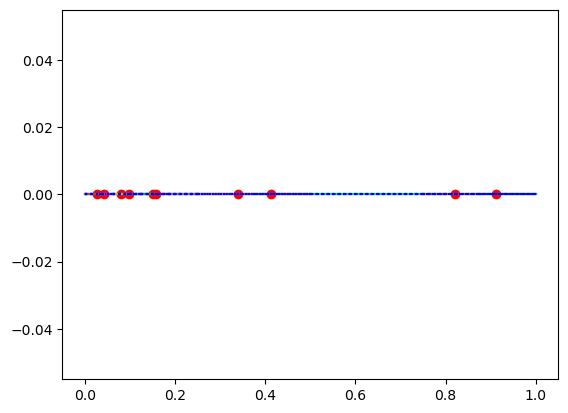

{'children': [{'children': [{'children': [{'children': [{'children': [{'children': None, 'data': ([4], [0.027487616570055384], 0.015625, 0.03125)}, {'children': None, 'data': ([0], [0.0422262406620636], 0.046875, 0.03125)}], 'data': ([0, 4], [0.0422262406620636, 0.027487616570055384], 0.03125, 0.0625)}, {'children': [{'children': None, 'data': ([6], [0.07912453721485058], 0.078125, 0.03125)}, {'children': None, 'data': ([7], [0.09822364464274214], 0.109375, 0.03125)}], 'data': ([6, 7], [0.07912453721485058, 0.09822364464274214], 0.09375, 0.0625)}], 'data': ([0, 4, 6, 7], [0.0422262406620636, 0.027487616570055384, 0.07912453721485058, 0.09822364464274214], 0.0625, 0.125)}, {'children': [{'children': [{'children': None, 'data': ([1], [0.15062510166613907], 0.140625, 0.03125)}, {'children': None, 'data': ([5], [0.15877777638867985], 0.171875, 0.03125)}], 'data': ([1, 5], [0.15062510166613907, 0.15877777638867985], 0.15625, 0.0625)}, {'children': None, 'data': ([], [], 0.21875, 0.0625)}], 

In [1]:
import jax
import jax.numpy as jnp
from jax import tree_util
import numpy as np
import matplotlib.pyplot as plt

def assign_to_segment(x, center_x):
    """Assigns a point to the left or right segment based on its position relative to center_x."""
    return int(x > center_x)

def split_points_1d(i_list, x_list, center_x):
    """Splits points into left and right segments."""
    segments_i = [[], []]
    segments_x = [[], []]
    for i, x in zip(i_list, x_list):
        idx = assign_to_segment(x, center_x)
        segments_i[idx].append(i)
        segments_x[idx].append(x)
    return segments_i, segments_x

def get_1d_tree(point_ids, points_x, center_x, width, max_points=1):
    """Recursively constructs a 1D tree."""
    if len(points_x) <= max_points:
        return {"children": None, "data": (point_ids, points_x, center_x, width)}
    else:
        segments_i, segments_x = split_points_1d(point_ids, points_x, center_x)
        center_x_list = (center_x - width / 4, center_x + width / 4)
        widths = (width / 2, width / 2)
        children = [
            get_1d_tree(i, x, cx, w)
            for i, x, cx, w in zip(segments_i, segments_x, center_x_list, widths)
        ]
        return {"children": children, "data": (point_ids, points_x, center_x, width)}

def plot_1d_tree(tree, **kwargs):
    """Visualizes the 1D tree as a series of line segments."""
    cx, w = tree["data"][-2:]
    plt.plot([cx - w / 2, cx + w / 2], [0, 0], **kwargs)
    children = tree["children"]
    if children is not None:
        for child in children:
            plot_1d_tree(child, **kwargs)

def get_coef_1d(point_ids, points_x, center_x, mu):
    """Computes coefficients for points based on their distance from the center."""
    z = jnp.array(points_x) - center_x
    return jnp.array([jnp.sum(mu[point_ids] * z**n) for n in range(5)])

def compute_coef_1d(tree, mu):
    """Adds coefficients to the 1D tree."""
    data = tree["data"]
    point_ids, points_x, center_x, width = data
    if len(points_x) == 0:
        return {"children": tree["children"], "data": (None, [], center_x, width)}
    else:
        c = get_coef_1d(point_ids, points_x, center_x, mu)
        new_data = (c, point_ids, points_x, center_x, width)
        return {"children": tree["children"], "data": new_data}

# Define a leaf predicate for JAX tree utilities
def is_leaf_1d(node):
    """Checks if a node is a leaf by ensuring it is a dictionary and has no children."""
    return isinstance(node, dict) and node.get("children") is None

# Example usage
N = 10
point_ids = np.arange(N)
points_x = np.random.rand(N)
center_x = 0.5
width = 1.0
mu = np.ones(N)

# Build the tree
tree_1d = get_1d_tree(point_ids, points_x, center_x, width, max_points=1)

# Plot the original tree
plot_1d_tree(tree_1d)
plt.scatter(points_x, [0] * N, color='red')

# Use JAX's tree utilities to map coefficient computation
new_tree_1d = tree_util.tree_map(
    lambda node: compute_coef_1d(node, mu) if is_leaf_1d(node) else node,
    tree_1d
)

# Plot the updated tree
plot_1d_tree(new_tree_1d, color='blue', linestyle=':')
plt.show()

print(new_tree_1d)
